# Deep Dream

In [1]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import inception_v3
from keras import backend as K
import numpy as np
import scipy

# フェーズを Test に設定
K.set_learning_phase(0)

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
using GPU: 0


画像の読み込み・前処理を行う関数

In [2]:
def load_image(img_file):
    img = load_img(img_file)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # img -> [img]
    img = inception_v3.preprocess_input(img)
    
    return img

テンソルから画像へ復元する関数

In [3]:
def deprocess_image(x):
    # フレームワークのフォーマットに合わせて変形
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    # 正規化を解除
    x = (x / 2.0 + 0.5) * 255.0
    # 値を 0 ~ 255 の範囲に収める
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

モデルを読み込む。
**InceptionV3**を使用

In [4]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
dream = model.input

レイヤーのlossの重みの設定

In [5]:
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

重みの設定をレイヤーに反映

In [6]:
# レイヤー名: レイヤー形式の辞書を作成
layer_dict = {layer.name: layer for layer in model.layers}

loss = K.variable(0.)
for layer_name in settings['features']:
    rate = settings['features'][layer_name]
    x = layer_dict[layer_name].output  # レイヤーの出力
    scaling = K.prod(K.cast(K.shape(x), 'float32'))  # 出力の要素数
    # 出力の周辺部を除いた特徴量の二乗和の平均に設定値を掛けたものを足し合わせる
    if K.image_data_format() == 'channels_first':
        loss += rate * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += rate * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# 勾配を計算
grads = K.gradients(loss, dream)[0]
# 勾配を正規化
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

lossと勾配を取得する関数

In [7]:
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    
    return loss_value, grad_values

画像をリサイズする関数

In [8]:
def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    
    return scipy.ndimage.zoom(img, factors, order=1)

最急上昇法

In [9]:
def gradient_ascent(x, iterations, step, max_loss=None):
    # max_loss を超えない範囲で勾配を強調する
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        x += step * grad_values
    
    return x

## 実験
ハイパーパラメータ

In [10]:
step = 0.01  # 最急上昇法の重み
num_octave = 3  # 最急上昇法の拡大数
octave_scale = 1.4  # 一回ごとの拡大率
iterations = 20  # 最急上昇法の実行回数
max_loss = 10.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def deep_dream(img_file):
    # 画像の読み込み
    img = load_image(img_file)
    # 画像の大きさを取得
    if K.image_data_format() == 'channels_first':
        original_shape = img.shape[2:]
    else:
        original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
    # 最急上昇法の実行ごとのサイズを計算
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]

    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0])  # 開始サイズにリサイズした画像

    for shape in successive_shapes:
        # 次のサイズの勾配が強調された画像を生成
        img = resize_img(img, shape)
        img = gradient_ascent(img,
                            iterations=iterations,
                            step=step,
                            max_loss=max_loss)  # 最急上昇法
        # 拡大による誤差を計算して足し合わせる
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        # 拡大画像を更新
        shrunk_original_img = resize_img(original_img, shape)

    plt.imshow(deprocess_image(np.copy(img)))

/usr/local/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


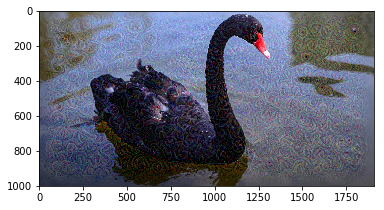

In [12]:
deep_dream('imgs/black_swan.jpg')

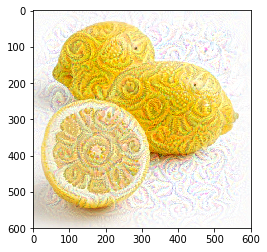

In [13]:
deep_dream('imgs/lemon.jpg')

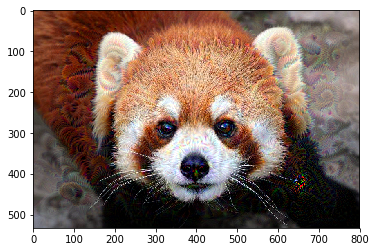

In [14]:
deep_dream('imgs/lesser_panda.jpg')